# Imports

In [12]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# Configuraciones iniciales de algunas constantes

In [46]:
CATEGORIAS = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('train')
VALIDATION_DIR = Path('test')
SIZE = 150

In [50]:
test_images = os.listdir(VALIDATION_DIR)
print(test_images)

['20056.jpg', '20057.jpg', '20058.jpg', '20059.jpg', '20060.jpg', '20061.jpg', '20062.jpg', '20064.jpg', '20066.jpg', '20067.jpg', '20068.jpg', '20069.jpg', '20070.jpg', '20071.jpg', '20072.jpg', '20073.jpg', '20074.jpg', '20075.jpg', '20076.jpg', '20077.jpg', '20078.jpg', '20079.jpg', '20080.jpg', '20081.jpg', '20082.jpg', '20083.jpg', '20084.jpg', '20085.jpg', '20087.jpg', '20088.jpg', '20089.jpg', '20090.jpg', '20091.jpg', '20092.jpg', '20093.jpg', '20094.jpg', '20095.jpg', '20096.jpg', '20098.jpg', '20099.jpg', '20100.jpg', '20106.jpg', '20107.jpg', '20108.jpg', '20109.jpg', '20111.jpg', '20112.jpg', '20113.jpg', '20114.jpg', '20115.jpg', '20116.jpg', '20117.jpg', '20120.jpg', '20123.jpg', '20124.jpg', '20126.jpg', '20127.jpg', '20129.jpg', '20131.jpg', '20133.jpg', '20134.jpg', '20136.jpg', '20137.jpg', '20138.jpg', '20140.jpg', '20142.jpg', '20144.jpg', '20147.jpg', '20148.jpg', '20150.jpg', '20151.jpg', '20152.jpg', '20153.jpg', '20154.jpg', '20157.jpg', '20158.jpg', '20159.jpg'

In [53]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    #horizontal_flip=True,
    #vertical_flip=True,
)
  
READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CATEGORIAS,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)
READ_PARAMS_TEST = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CATEGORIAS,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

# Obtenemos los conjuntos de train y validation

In [64]:
import numpy as np
from keras.preprocessing import image

def load_test_images(test_dir):
    test_images = []
    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        img = image.load_img(img_path, target_size=(SIZE, SIZE))
        img_array = image.img_to_array(img) / 255.0
        test_images.append(img_array)
    return np.array(test_images)
  
test_images = load_test_images("test")

In [70]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow(test_images)

Found 14034 images belonging to 6 classes.


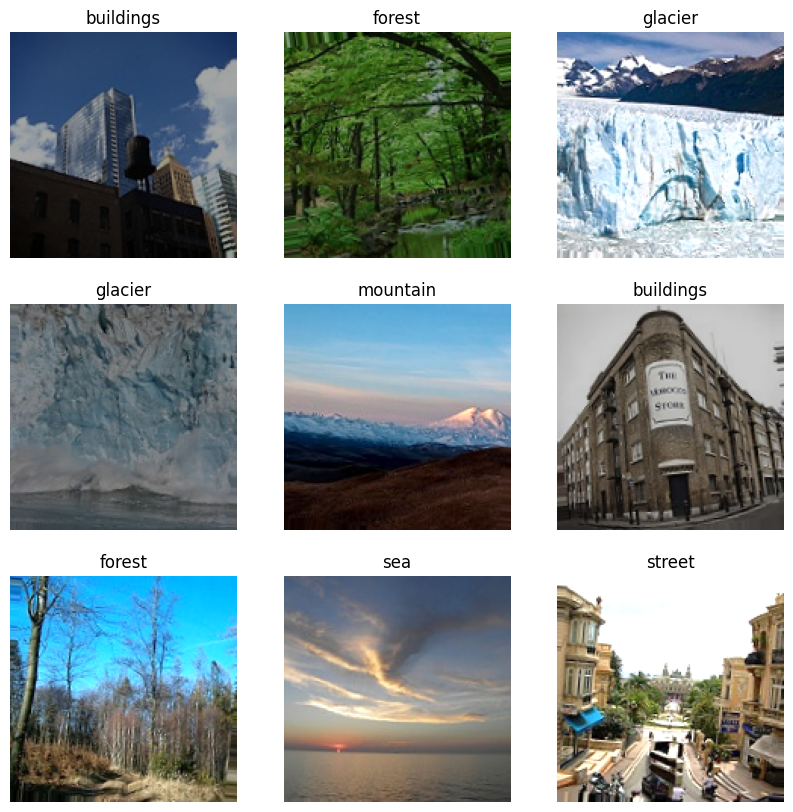

In [72]:
# Para mostrar algunas imagenes del dataset
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CATEGORIAS[np.argmax(labels[i])])
        plt.axis("off")
def sample_images_test(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

sample_images(train)

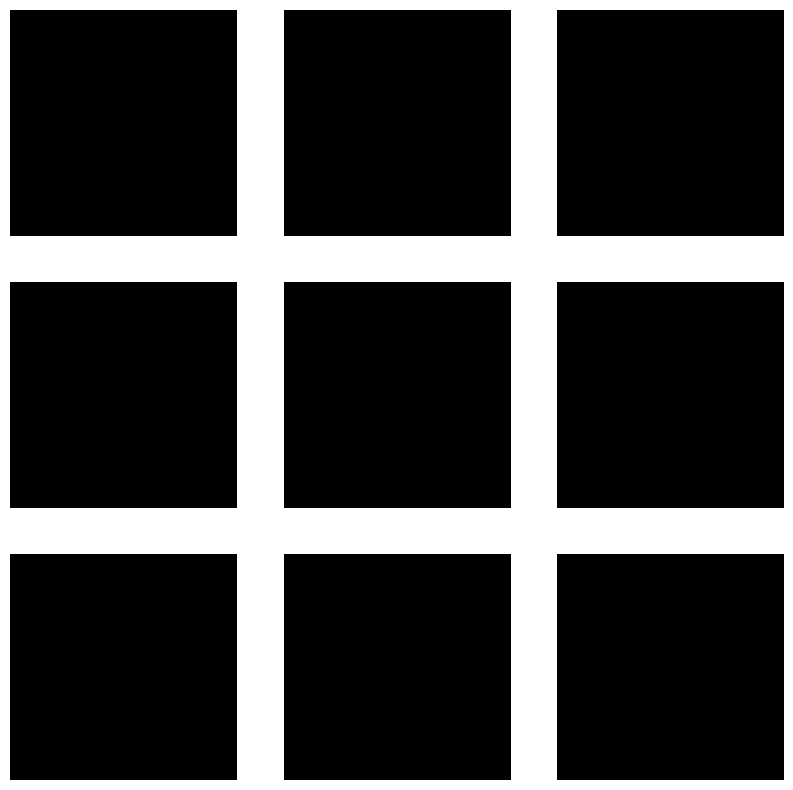

In [73]:
sample_images_test(validation)

# Análisis exploratorio del conjunto de datos

Se explorará:
- Volumetría de los datos
- Estructura y tipo de las imágenes
- Distribución de la variable a predecir

El dataset de imagenes con el que vamos a trabajar se encuentra divido en 2 carpetas, train y test. 

En el set de train se encuentra dividido en 6 carpetas, cada una de estas hace referencia a las diferentes categorias que queremos predecir. Cada una de estas carpetas contiene 2000 imagenes aproximadamente. En el set de test tenemos 3000 imagenes, en las cuales se van a encontrar imagenes de las diferentes categorias para poder predecir a cual pertenece cada una.

Las imagenes tienen un tamaño de 150x150, 3 canales de color, y se encuentran en formato JPG. 



# Modelado

## Empezamos a trabajar con las redes neuronales

In [17]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

In [18]:
# MLP simple
model = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIAS), activation='softmax'),
])

In [19]:
# Convolucional
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIAS), activation='softmax'),
])

In [20]:
# Convolucional usando convoluciones ya entrenadas de VGG16
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CATEGORIAS), activation='softmax'),
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       819,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,544,694 (59.30 MB)

 Trainable params: 830,006 (3.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [23]:
history = model.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

c:\ML\TP_2_ML_Bellotti_Lopez_Trinchieri\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.7584 - loss: 0.6691

ValueError: Must provide at least one structure

Vemos el accuracy de ambos conjuntos, tanto train como validation, durante todo el proceso

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Elegimos la que consideremos como la mejor epoca y nos quedamos con ese conjunto de pesos

In [ ]:
BEST_EPOCH = 4
model.set_weights(model_weights_at_epochs[BEST_EPOCH])

Ahora analizamos el error de ambos conjuntos para sacar nuestras propias conclusiones

In [ ]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=-1)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=-1)),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = next(dataset)
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('Accuracy:', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1, 2], CATEGORIAS, rotation=45)
    plt.yticks([0, 1, 2], CATEGORIAS)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

## Ahora probaremos con nuestras propias imágenes!

In [ ]:
from IPython.display import Image, display


def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", CATEGORIAS[np.argmax(predictions)])
    print("Prediction detail:", predictions)
show_and_predict("./fisa_pelado.jpg")

# Conclusiones